In [58]:
from keras import models, layers, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
import matplotlib.pyplot as plt
import numpy as np

### Build Model

In [53]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', 
                        input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 15, 15, 128)     

In [54]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

### Data Preprocessing
flow_from_directory is very powerful, especially for images

In [55]:
train_datagen = ImageDataGenerator(rescale=1./255) # rescales into RGB
test_datagen = ImageDataGenerator(rescale=1./255)

# assumes class dirs within the ./train dir
train_generator = train_datagen.flow_from_directory(
    './train',
    target_size=(150,150), # resizes all images to 150x150
    batch_size=20,
    class_mode='binary'    # binary labels
)

validation_generator = test_datagen.flow_from_directory(
    './validation',
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
for data_batch, label_batch in train_generator:
    print('data batch shape', data_batch.shape)
    print('label batch shape', label_batch.shape)
    break

data batch shape (20, 150, 150, 3)
label batch shape (20,)


Data batches hold 20 images of size 150x150 with 3 channels (RGB). Also, the flow_from_directory fn inferred and created labels

### Fitting the Model

In [56]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100, # 20 samples/batch*100 = 2000 total trng samples
    epochs=10, # book uses 30, but that's too much for my computer
)

# save the model!
model.save('cats_and_dogs_small_1.h5')

Epoch 1/10
  4/100 [>.............................] - ETA: 2:11 - loss: 0.7047 - acc: 0.4500

KeyboardInterrupt: 

A note on steps_per_epoch, this arg determines how many samples to draw from the generator before an epoch is over. Note also that gradient descent is run steps_for_epoch times during each epoch

In [20]:
hist = history.history
hist.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

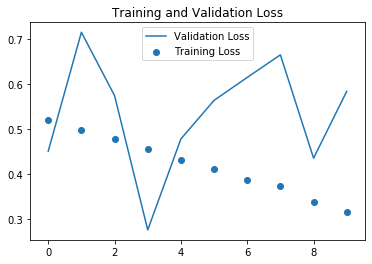

In [24]:
plt.plot(range(10), hist['val_loss'], label='Validation Loss')
plt.scatter(range(10), hist['loss'], label='Training Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

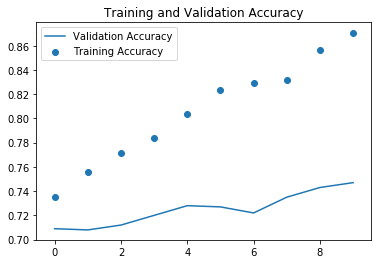

In [25]:
plt.plot(range(10), hist['val_acc'], label='Validation Accuracy')
plt.scatter(range(10), hist['acc'], label='Training Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Clear signs of overfitting as training accuracy increases and validation stalls out

### Data Augmentation
This technique works very well for computer vision. Basically, it generates augmented images so that, ideally, the model never sees a larger number of images and is able to generalize better

In [ ]:
# use ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,      # random rotations
    width_shift_range=0.2,  # random horizontal translation
    height_shift_range=0.2, # random vertical translation
    shear_range=0.2,        # shearing transformation
    zoom_rage=0.2,          # zoom
    horizontal_flip=True,   # good for when there are no assumptions of horizontal symmetry
    fill_mode='nearest'     # strategy for filling in newly created pixels
)

### New Convnet
Using dropout and data augmentation for the training data.  
Recall dropout, applied to a layer during training, consists of randomly setting to zero a number of output features 

In [30]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', 
                        input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(512, activation='relu')) # why 512?
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 15, 15, 128)      

In [28]:
# Note, only apply data augmentation to training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    './train',
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    './validation',
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [31]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50
)

model.save('cats_and_dogs_small_2.h5')

Epoch 1/10
100/100 [==============================] - 211s 2s/step - loss: 0.6926 - acc: 0.5173 - val_loss: 0.6790 - val_acc: 0.6040
Epoch 2/10
100/100 [==============================] - 215s 2s/step - loss: 0.6757 - acc: 0.5707 - val_loss: 0.7012 - val_acc: 0.6080
Epoch 3/10
100/100 [==============================] - 241s 2s/step - loss: 0.6586 - acc: 0.5977 - val_loss: 0.6321 - val_acc: 0.5420
Epoch 4/10
100/100 [==============================] - 262s 3s/step - loss: 0.6406 - acc: 0.6291 - val_loss: 0.6134 - val_acc: 0.6360
Epoch 5/10
100/100 [==============================] - 281s 3s/step - loss: 0.6287 - acc: 0.6423 - val_loss: 0.6188 - val_acc: 0.6170
Epoch 6/10
100/100 [==============================] - 220s 2s/step - loss: 0.6238 - acc: 0.6533 - val_loss: 0.4986 - val_acc: 0.6850
Epoch 7/10
100/100 [==============================] - 215s 2s/step - loss: 0.6073 - acc: 0.6739 - val_loss: 0.4753 - val_acc: 0.6780
Epoch 8/10
100/100 [==============================] - 240s 2s/step - 

In [35]:
hist = history.history
hist.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

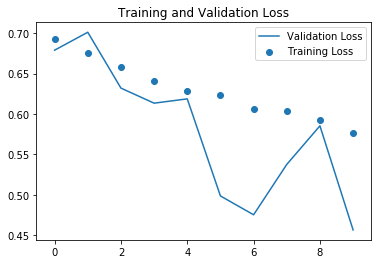

In [36]:
plt.plot(range(10), hist['val_loss'], label='Validation Loss')
plt.scatter(range(10), hist['loss'], label='Training Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

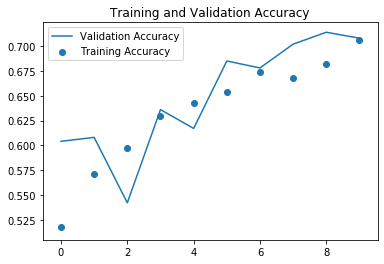

In [37]:
plt.plot(range(10), hist['val_acc'], label='Validation Accuracy')
plt.scatter(range(10), hist['acc'], label='Training Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Much better! Notice how the validation curve follows the training. Note that better results can be achieved with more epochs, but I'm on a laptop from 2012...

### Using a Pretrained Deep Learning Model
Note that we'll only use the convolutional portion, not the dense layer on top

In [34]:
conv_base = VGG16(weights='imagenet',
                  include_top=False, # don't include dense classifier on top of convulational layers
                  input_shape=(150,150,3))
conv_base.summary()

58892288/58889256 [==============================] - 509s 9us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
____________________________________________________________

**Option 1:** Fast feature extraction w/out data augmentation  
This option is fast because you only have run the images through the convnet once 

Run the images through the pretrained classifier's convolutional base and form new features and labels

In [62]:
datagen = ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # comes from output layer above
    labels = np.zeros(shape=(sample_count))
    gen = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in gen:
        features_batch = conv_base.predict(inputs_batch)
        features[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = features_batch
        labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = labels_batch
        i+=1
        if i * BATCH_SIZE >= sample_count: # if every image has been seen
            break # generators yield data indefinitely, need a break
    return features, labels

train_features, train_labels = extract_features('./train', 2000)
validation_features, validation_labels = extract_features('./validation', 1000)
test_features, test_labels = extract_features('./test', 1000)

Found 1000 images belonging to 2 classes.


Define the densely connected classifier that goes on top of the output above

In [63]:
# first need to flatten the features from above into samples x feature vector
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

In [66]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=(4*4*512)))
model.add(layers.Dropout(0.5)) # for regularization
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                        epochs=10,
                        batch_size=20,
                        validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 5s 2ms/step - loss: 0.5893 - acc: 0.6805 - val_loss: 0.4250 - val_acc: 0.8500
Epoch 2/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4206 - acc: 0.8080 - val_loss: 0.3578 - val_acc: 0.8660
Epoch 3/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3539 - acc: 0.8345 - val_loss: 0.3335 - val_acc: 0.8720
Epoch 4/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3120 - acc: 0.8720 - val_loss: 0.3148 - val_acc: 0.8770
Epoch 5/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2936 - acc: 0.8720 - val_loss: 0.3021 - val_acc: 0.8740
Epoch 6/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2679 - acc: 0.8935 - val_loss: 0.2930 - val_acc: 0.8850
Epoch 7/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2461 - acc: 0.8975 - val_loss: 0.2854 - val_acc: 0.8840
Epoch 8/10
200

In [67]:
hist = history.history
hist.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

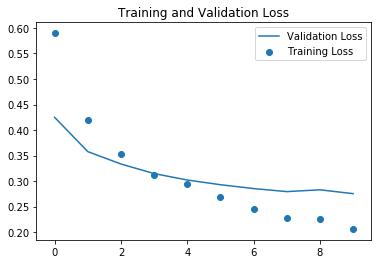

In [68]:
plt.plot(range(10), hist['val_loss'], label='Validation Loss')
plt.scatter(range(10), hist['loss'], label='Training Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

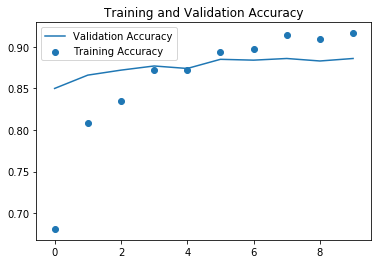

In [69]:
plt.plot(range(10), hist['val_acc'], label='Validation Accuracy')
plt.scatter(range(10), hist['acc'], label='Training Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

**Option 2:** Combine the pretrained convolutional base with your own densely connected layer.  
(Note that this MUST be done on a GPU) The advantage of this method is you can perform data augmentation

1. Freeze the layers in the pretrained network so their weights don't update
2. Add a Flatten layer followed by the densely connected layers

**Fine Tuning**  
Basic idea is to unfreeze the top layers of the pretrained network to allow those weights to update as well  
1. Add dense network on top of base network
2. Freeze the base network
3. Train the dense network from step 1. using all layers
4. Unfreeze some layers in the base network
5. Jointly train all unfrozen layers in both the convnet and dense net

**Final Note:** Don't forget that data augmentation is the best way to fight overfitting when performing classifications tasks using images